Demo for GRxnODE

This demo includes a brief tutorial for GRxnODE:
1. Dataset requirements
2. Model Training
3. Model Visualization




""" Get data from dataset = {"time_data": time_data,
                                 "y_data": y_data,
                                "p_data": p_data,
                                "y0_data": y0_data}
        process input: p_data = [numpy[t;p1], numpy[t,p2], ...]
                       (default var:  [[y_in], [F]])
        y0_data: initial condition of reactors, all reactors required if N>1
    """


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


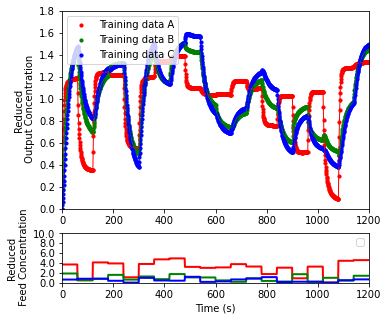

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


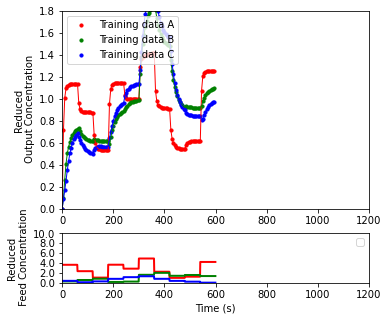

In [1]:
from Data.CSTR_ideal import get_data
from Engine.data_visualizer import data_vis

trainset_1, testset_1, data_scale = get_data(f=1, s=5)

data_vis(trainset_1)
data_vis(testset_1)

In [2]:
import Engine.Trainer as Trainer
from Engine.cfg import CFG

cfg = CFG()
trainsets = [trainset_1, ]
testsets = [testset_1, ]

cfg.ode_rtol = 0.01
cfg.ode_atol = 0.001
cfg.epoch = 300
cfg.lr_step_size = [200, ]

trainer = Trainer.RTD(cfg, trainsets, testsets)
trainer.train()

D:\Pyprojects\GRxnODE\Model_Zoo\Model_Zoo.py:45: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is C:\Users\56504\AppData\Local\Temp/torch/kernels. This warning will appear only once per process. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cuda\jit_utils.cpp:860.)
  RTD_r = self.t ** (n - 1) / torch.lgamma(n).exp() * (n ** n) * (-self.t * n).exp()


itr:10  time:(1m 43s) loss:0.5287 lr:0.0050 0.0100
Test error = 0.5044
itr:20  time:(3m 24s) loss:0.3678 lr:0.0050 0.0100
Test error = 0.4603
itr:30  time:(5m 7s) loss:0.2659 lr:0.0050 0.0100
Test error = 0.3094
itr:40  time:(6m 54s) loss:0.1694 lr:0.0050 0.0100
Test error = 0.2090
itr:50  time:(8m 38s) loss:0.1437 lr:0.0050 0.0100
Test error = 0.1883
itr:60  time:(10m 23s) loss:0.1388 lr:0.0050 0.0100
Test error = 0.1876
itr:70  time:(12m 9s) loss:0.1373 lr:0.0050 0.0100
Test error = 0.1755
itr:80  time:(13m 55s) loss:0.1239 lr:0.0050 0.0100
Test error = 0.1372
itr:90  time:(15m 36s) loss:0.1050 lr:0.0050 0.0100
Test error = 0.1100
itr:100  time:(17m 21s) loss:0.0830 lr:0.0050 0.0100
Test error = 0.0774
itr:110  time:(19m 6s) loss:0.0771 lr:0.0050 0.0100
Test error = 0.1069
itr:120  time:(20m 50s) loss:0.0856 lr:0.0050 0.0100
Test error = 0.1130
itr:130  time:(22m 36s) loss:0.0895 lr:0.0050 0.0100
Test error = 0.0962
itr:140  time:(24m 19s) loss:0.0858 lr:0.0050 0.0100
Test error = 0.

D:\Pyprojects\GRxnODE\Model_Zoo\Model_Zoo.py:45: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is C:\Users\56504\AppData\Local\Temp/torch/kernels. This warning will appear only once per process. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cuda\jit_utils.cpp:860.)
  RTD_r = self.t ** (n - 1) / torch.lgamma(n).exp() * (n ** n) * (-self.t * n).exp()


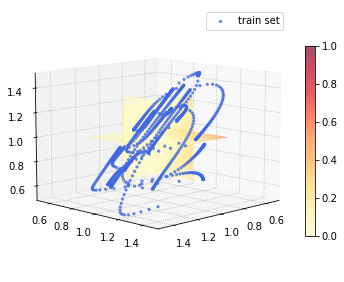

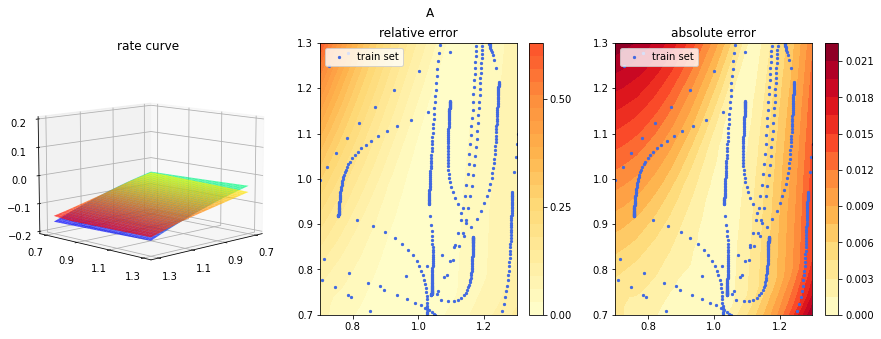

<Figure size 432x288 with 0 Axes>

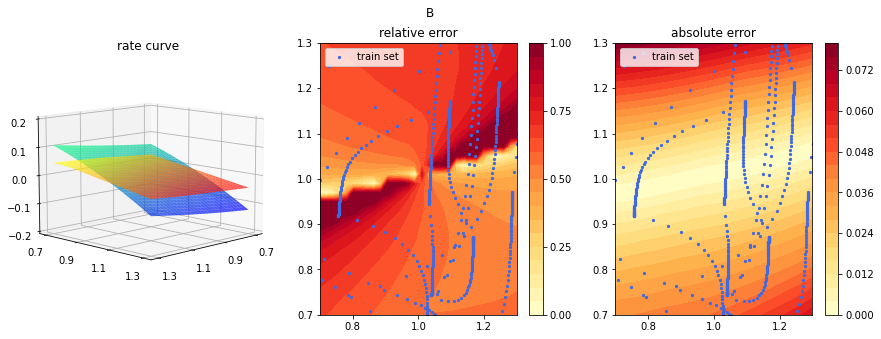

<Figure size 432x288 with 0 Axes>

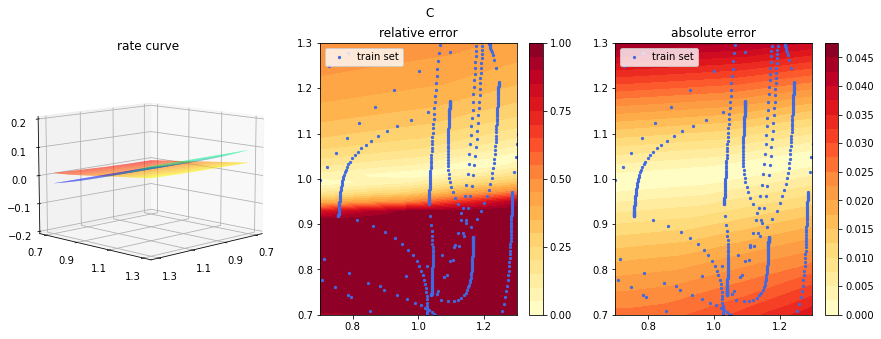

<Figure size 432x288 with 0 Axes>

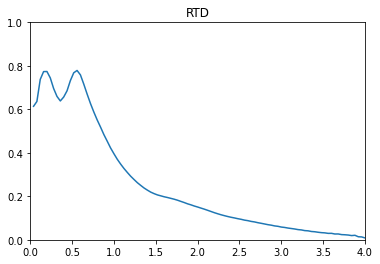

In [1]:
from Engine.model_visualizer import Visualizer
import torch



model_path = r"output/test_model.pth"
trainer.model.load_state_dict(torch.load(model_path))

visualizer = Visualizer(trainer.model, trainsets, data_scale, cfg)
visualizer.run()